Experiment E1-2:
- binary classification
- dataset train 3500, val 1500
- BATCH_SIZE = 20
- IMAGE_SIZE = 256
- EPOCHS = 20
- criterion = nn.BCEWithLogitsLoss()
- optimizer = SGD
- lr=1.0e-4

model:
- self.base_model(x)
- self.globalavg(x)
- self.flatten(x)
- self.fc(x)

In [1]:
import numpy as np
import os
import sys
import glob
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torchvision import transforms, models
import torchvision
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from PIL import Image

In [2]:
# load common py
sys.path.append('../src')
import config
import common_utils
import data_utils
import train_utils
import plot_utils


In [3]:
# override config for experiment
EXP_CODE = "E1-2"
SAVE_FILENAME = f"stage1-{EXP_CODE}-metrics"

config.EPOCHS = 20

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

common_utils.set_seed(config.SEED)


In [5]:
df = pd.read_csv(config.TRAIN_CSV)

In [6]:
# split data into train, val, test 70/15/15
# for fast training, use only 3500 and 1500 samples for train and val

train_df, val_df, test_df, train_small_df, val_small_df = data_utils.split_data(df, config.SEED, small_train_size=3500, small_val_size=1500)

In [7]:
# create transforms
train_transform = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),   
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_val_transform = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [8]:
# create datasets
train_small_dataset = data_utils.SteelDataset(df=train_small_df, 
                                    data_folder=config.IMAGE_FOLDER,
                                    transforms=train_transform,
                                    image_size=config.IMAGE_SIZE,
                                    return_tensor=True
                                    )
val_small_dataset = data_utils.SteelDataset(df=val_small_df, 
                                    data_folder=config.IMAGE_FOLDER,
                                    transforms=test_val_transform,
                                    image_size=config.IMAGE_SIZE,
                                    return_tensor=True
                                   )


In [9]:
train_small_loader = DataLoader(train_small_dataset, batch_size=config.BATCH_SIZE,
                          shuffle=True,
                          num_workers=config.NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=config.PREFETCH_FACTOR
                          )

val_small_loader = DataLoader(val_small_dataset, batch_size=config.BATCH_SIZE,
                         shuffle=False,
                         num_workers=config.NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=config.PREFETCH_FACTOR
                         )


In [10]:
# create model
class SteelModel(nn.Module):
    def __init__(self):
        super(SteelModel, self).__init__()

        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1').features
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Remove original classifier
        #self.base_model.classifier = nn.Identity()

        self.globalavg = nn.AdaptiveAvgPool2d((1, 1))

        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(1280, 1),
        )
               

    def forward(self, x):
        x = self.base_model(x)
        #print(x.shape)
        x = self.globalavg(x)
        #print(x.shape)
        x = self.flatten(x)
        #print(x.shape)
        x = self.fc(x)
        #print(x.shape)
        return x 

In [11]:
model = SteelModel()
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=config.LEARNING_RATE)

In [12]:
%%time

arr_train_acc = []
arr_train_loss = []
arr_train_precision = []
arr_train_recall = []
arr_train_f1 = []
arr_train_rocauc = []
arr_train_conf_matrix = []

arr_val_acc = []
arr_val_loss = []
arr_val_precision = []
arr_val_recall = []
arr_val_f1 = []
arr_val_rocauc = []
arr_val_conf_matrix = []

idx = 0
for epoch in range(config.EPOCHS):
    train_loss, train_all_labels, train_all_preds, train_all_probs = train_utils.train_one_epoch(model, train_small_loader, criterion, optimizer, device)
    val_loss, val_all_labels, val_all_preds, val_all_probs = train_utils.validate_one_epoch(model, val_small_loader, criterion, device)

    # train metrics
    train_accuracy = (train_all_preds == train_all_labels).mean()
    train_precision = precision_score(train_all_labels, train_all_preds)
    train_recall = recall_score(train_all_labels, train_all_preds)
    train_f1 = f1_score(train_all_labels, train_all_preds)
    train_rocauc = roc_auc_score(train_all_labels, train_all_probs)
    train_conf_matrix = confusion_matrix(train_all_labels, train_all_preds)
    train_tn, train_fp, train_fn, train_tp = train_conf_matrix.ravel()
    
    arr_train_loss.append(train_loss)
    arr_train_acc.append(train_accuracy)
    arr_train_precision.append(train_precision)
    arr_train_recall.append(train_recall)
    arr_train_f1.append(train_f1)
    arr_train_rocauc.append(train_rocauc)
    arr_train_conf_matrix.append({'tn': train_tn, 'fp': train_fp, 'fn': train_fn, 'tp': train_tp})

    # val metrics
    val_accuracy = (val_all_preds == val_all_labels).mean()
    val_precision = precision_score(val_all_labels, val_all_preds)
    val_recall = recall_score(val_all_labels, val_all_preds)
    val_f1 = f1_score(val_all_labels, val_all_preds)
    val_rocauc = roc_auc_score(val_all_labels, val_all_probs)
    val_conf_matrix = confusion_matrix(val_all_labels, val_all_preds)
    val_tn, val_fp, val_fn, val_tp = val_conf_matrix.ravel()

    arr_val_loss.append(val_loss)
    arr_val_acc.append(val_accuracy)
    arr_val_precision.append(val_precision)
    arr_val_recall.append(val_recall)
    arr_val_f1.append(val_f1)
    arr_val_rocauc.append(val_rocauc)
    arr_val_conf_matrix.append({'tn': val_tn, 'fp': val_fp, 'fn': val_fn, 'tp': val_tp})

    print(idx+1)
    print(f"Epoch {epoch+1}/{config.EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f}")
    print(f"  Val Loss  : {val_loss:.4f} | Val Acc: {val_accuracy:.4f}")
    print(f"  Train Precision: {train_precision:.4f} | Recall: {train_recall:.4f} | F1: {train_f1:.4f} | ROC AUC: {train_rocauc:.4f}")
    print(f"  Train Confusion Matrix: TN={train_tn}, FP={train_fp}, FN={train_fn}, TP={train_tp}")
    print(f"  Val Precision: {val_precision:.4f} | Recall: {val_recall:.4f} | F1: {val_f1:.4f} | ROC AUC: {val_rocauc:.4f}")
    print(f"  Val Confusion Matrix: TN={val_tn}, FP={val_fp}, FN={val_fn}, TP={val_tp}")

    idx += 1
    #break


1
Epoch 1/20
  Train Loss: 0.7049 | Train Acc: 0.5077
  Val Loss  : 0.6906 | Val Acc: 0.5280
  Train Precision: 0.5754 | Recall: 0.3752 | F1: 0.4542 | ROC AUC: 0.5217
  Train Confusion Matrix: TN=1060, FP=529, FN=1194, TP=717
  Val Precision: 0.5595 | Recall: 0.6374 | F1: 0.5959 | ROC AUC: 0.5288
  Val Confusion Matrix: TN=270, FP=411, FN=297, TP=522
2
Epoch 2/20
  Train Loss: 0.6824 | Train Acc: 0.5571
  Val Loss  : 0.6825 | Val Acc: 0.5607
  Train Precision: 0.5784 | Recall: 0.6965 | F1: 0.6320 | ROC AUC: 0.5658
  Train Confusion Matrix: TN=619, FP=970, FN=580, TP=1331
  Val Precision: 0.5769 | Recall: 0.7326 | F1: 0.6455 | ROC AUC: 0.5591
  Val Confusion Matrix: TN=241, FP=440, FN=219, TP=600
3
Epoch 3/20
  Train Loss: 0.6734 | Train Acc: 0.5857
  Val Loss  : 0.6746 | Val Acc: 0.5820
  Train Precision: 0.5936 | Recall: 0.7650 | F1: 0.6685 | ROC AUC: 0.6031
  Train Confusion Matrix: TN=588, FP=1001, FN=449, TP=1462
  Val Precision: 0.5815 | Recall: 0.8364 | F1: 0.6860 | ROC AUC: 0.59

In [13]:
df_metrics = train_utils.build_metric_df(
    arr_train_loss, arr_train_acc, arr_train_precision, arr_train_recall, 
    arr_train_f1, arr_train_rocauc, arr_train_conf_matrix,
    arr_val_loss, arr_val_acc, arr_val_precision, arr_val_recall, 
    arr_val_f1, arr_val_rocauc, arr_val_conf_matrix
)


In [14]:
df_metrics

,train_loss,train_acc,train_precision,train_recall,train_f1,train_rocauc,train_conf_matrix,val_loss,val_acc,val_precision,...,val_rocauc,val_conf_matrix,train_tn,train_fp,train_fn,train_tp,val_tn,val_fp,val_fn,val_tp
0,0.704938,0.507714,0.575441,0.375196,0.454229,0.521668,"{'tn': 1060, 'fp': 529, 'fn': 1194, 'tp': 717}",0.690591,0.528000,0.559486,...,0.528826,"{'tn': 270, 'fp': 411, 'fn': 297, 'tp': 522}",1060,529,1194,717,270,411,297,522
1,0.682435,0.557143,0.578444,0.696494,0.632004,0.565806,"{'tn': 619, 'fp': 970, 'fn': 580, 'tp': 1331}",0.682539,0.560667,0.576923,...,0.559089,"{'tn': 241, 'fp': 440, 'fn': 219, 'tp': 600}",619,970,580,1331,241,440,219,600
2,0.673401,0.585714,0.593585,0.765044,0.668496,0.603087,"{'tn': 588, 'fp': 1001, 'fn': 449, 'tp': 1462}",0.674644,0.582000,0.581494,...,0.594386,"{'tn': 188, 'fp': 493, 'fn': 134, 'tp': 685}",588,1001,449,1462,188,493,134,685
3,0.664502,0.604857,0.601460,0.818943,0.693552,0.634547,"{'tn': 552, 'fp': 1037, 'fn': 346, 'tp': 1565}",0.661552,0.610667,0.601032,...,0.647120,"{'tn': 217, 'fp': 464, 'fn': 120, 'tp': 699}",552,1037,346,1565,217,464,120,699
4,0.657608,0.625143,0.614971,0.838305,0.709477,0.656939,"{'tn': 586, 'fp': 1003, 'fn': 309, 'tp': 1602}",0.659260,0.618667,0.603003,...,0.654295,"{'tn': 205, 'fp': 476, 'fn': 96, 'tp': 723}",586,1003,309,1602,205,476,96,723
5,0.651846,0.638286,0.626620,0.835165,0.716016,0.677033,"{'tn': 638, 'fp': 951, 'fn': 315, 'tp': 1596}",0.650827,0.653333,0.633126,...,0.682204,"{'tn': 269, 'fp': 412, 'fn': 108, 'tp': 711}",638,951,315,1596,269,412,108,711
6,0.645528,0.646000,0.630739,0.848247,0.723499,0.694303,"{'tn': 640, 'fp': 949, 'fn': 290, 'tp': 1621}",0.644545,0.662667,0.635264,...,0.703404,"{'tn': 259, 'fp': 422, 'fn': 84, 'tp': 735}",640,949,290,1621,259,422,84,735
7,0.640091,0.657143,0.641127,0.845107,0.729120,0.708548,"{'tn': 685, 'fp': 904, 'fn': 296, 'tp': 1615}",0.639493,0.673333,0.643920,...,0.712161,"{'tn': 274, 'fp': 407, 'fn': 83, 'tp': 736}",685,904,296,1615,274,407,83,736
8,0.632018,0.672000,0.650256,0.863946,0.742022,0.728317,"{'tn': 701, 'fp': 888, 'fn': 260, 'tp': 1651}",0.631692,0.680667,0.652878,...,0.729316,"{'tn': 295, 'fp': 386, 'fn': 93, 'tp': 726}",701,888,260,1651,295,386,93,726
9,0.628768,0.671714,0.653877,0.847200,0.738090,0.732803,"{'tn': 732, 'fp': 857, 'fn': 292, 'tp': 1619}",0.624455,0.694000,0.668539,...,0.746231,"{'tn': 327, 'fp': 354, 'fn': 105, 'tp': 714}",732,857,292,1619,327,354,105,714


In [15]:
print('Val Metrics:')
print(df_metrics[config.VAL_METRICS])
print('')
print('Val Confusion Matrix:')
print(df_metrics[config.VAL_CF])

Val Metrics:
    val_loss   val_acc  val_precision  val_recall    val_f1  val_rocauc
0   0.690591  0.528000       0.559486    0.637363  0.595890    0.528826
1   0.682539  0.560667       0.576923    0.732601  0.645508    0.559089
2   0.674644  0.582000       0.581494    0.836386  0.686029    0.594386
3   0.661552  0.610667       0.601032    0.853480  0.705348    0.647120
4   0.659260  0.618667       0.603003    0.882784  0.716551    0.654295
5   0.650827  0.653333       0.633126    0.868132  0.732235    0.682204
6   0.644545  0.662667       0.635264    0.897436  0.743927    0.703404
7   0.639493  0.673333       0.643920    0.898657  0.750255    0.712161
8   0.631692  0.680667       0.652878    0.886447  0.751942    0.729316
9   0.624455  0.694000       0.668539    0.871795  0.756757    0.746231
10  0.620965  0.696000       0.665451    0.891331  0.762004    0.753836
11  0.617276  0.701333       0.665773    0.909646  0.768834    0.759249
12  0.612361  0.700000       0.663130    0.915751  

In [16]:
df_metrics.describe()

,train_loss,train_acc,train_precision,train_recall,train_f1,train_rocauc,val_loss,val_acc,val_precision,val_recall,val_f1,val_rocauc,train_tn,train_fp,train_fn,train_tp,val_tn,val_fp,val_fn,val_tp
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.00000,20.00000
mean,0.631413,0.660071,0.647762,0.820748,0.721258,0.710519,0.629246,0.669167,0.645757,0.872344,0.741676,0.718288,741.800000,847.200000,342.550000,1568.450000,289.300000,391.700000,104.55000,714.45000
std,0.032994,0.058588,0.038532,0.113379,0.072904,0.077915,0.032371,0.058826,0.040450,0.070203,0.050098,0.082819,122.140385,122.140385,216.667457,216.667457,48.141349,48.141349,57.49643,57.49643
min,0.587379,0.507714,0.575441,0.375196,0.454229,0.521668,0.586052,0.528000,0.559486,0.637363,0.595890,0.528826,552.000000,529.000000,239.000000,717.000000,188.000000,327.000000,56.00000,522.00000
25%,0.604564,0.635000,0.623707,0.837520,0.714381,0.672010,0.602797,0.644667,0.625595,0.869963,0.728314,0.675226,639.500000,759.250000,249.250000,1600.500000,266.500000,353.000000,74.00000,712.50000
50%,0.626281,0.677714,0.656633,0.860021,0.745955,0.736185,0.622710,0.695000,0.663579,0.894383,0.759380,0.750034,746.000000,843.000000,267.500000,1643.500000,299.500000,381.500000,86.50000,732.50000
75%,0.653286,0.703714,0.678356,0.869571,0.762269,0.770743,0.652935,0.712667,0.676407,0.909646,0.773461,0.777872,829.750000,949.500000,310.500000,1661.750000,328.000000,414.500000,106.50000,745.00000
max,0.704938,0.723143,0.697236,0.874935,0.774599,0.790956,0.690591,0.726667,0.689177,0.931624,0.785455,0.803657,1060.000000,1037.000000,1194.000000,1672.000000,354.000000,493.000000,297.00000,763.00000


In [17]:
print(df_metrics.describe())

       train_loss  train_acc  train_precision  train_recall   train_f1  \
count   20.000000  20.000000        20.000000     20.000000  20.000000   
mean     0.631413   0.660071         0.647762      0.820748   0.721258   
std      0.032994   0.058588         0.038532      0.113379   0.072904   
min      0.587379   0.507714         0.575441      0.375196   0.454229   
25%      0.604564   0.635000         0.623707      0.837520   0.714381   
50%      0.626281   0.677714         0.656633      0.860021   0.745955   
75%      0.653286   0.703714         0.678356      0.869571   0.762269   
max      0.704938   0.723143         0.697236      0.874935   0.774599   

       train_rocauc   val_loss    val_acc  val_precision  val_recall  \
count     20.000000  20.000000  20.000000      20.000000   20.000000   
mean       0.710519   0.629246   0.669167       0.645757    0.872344   
std        0.077915   0.032371   0.058826       0.040450    0.070203   
min        0.521668   0.586052   0.528000    

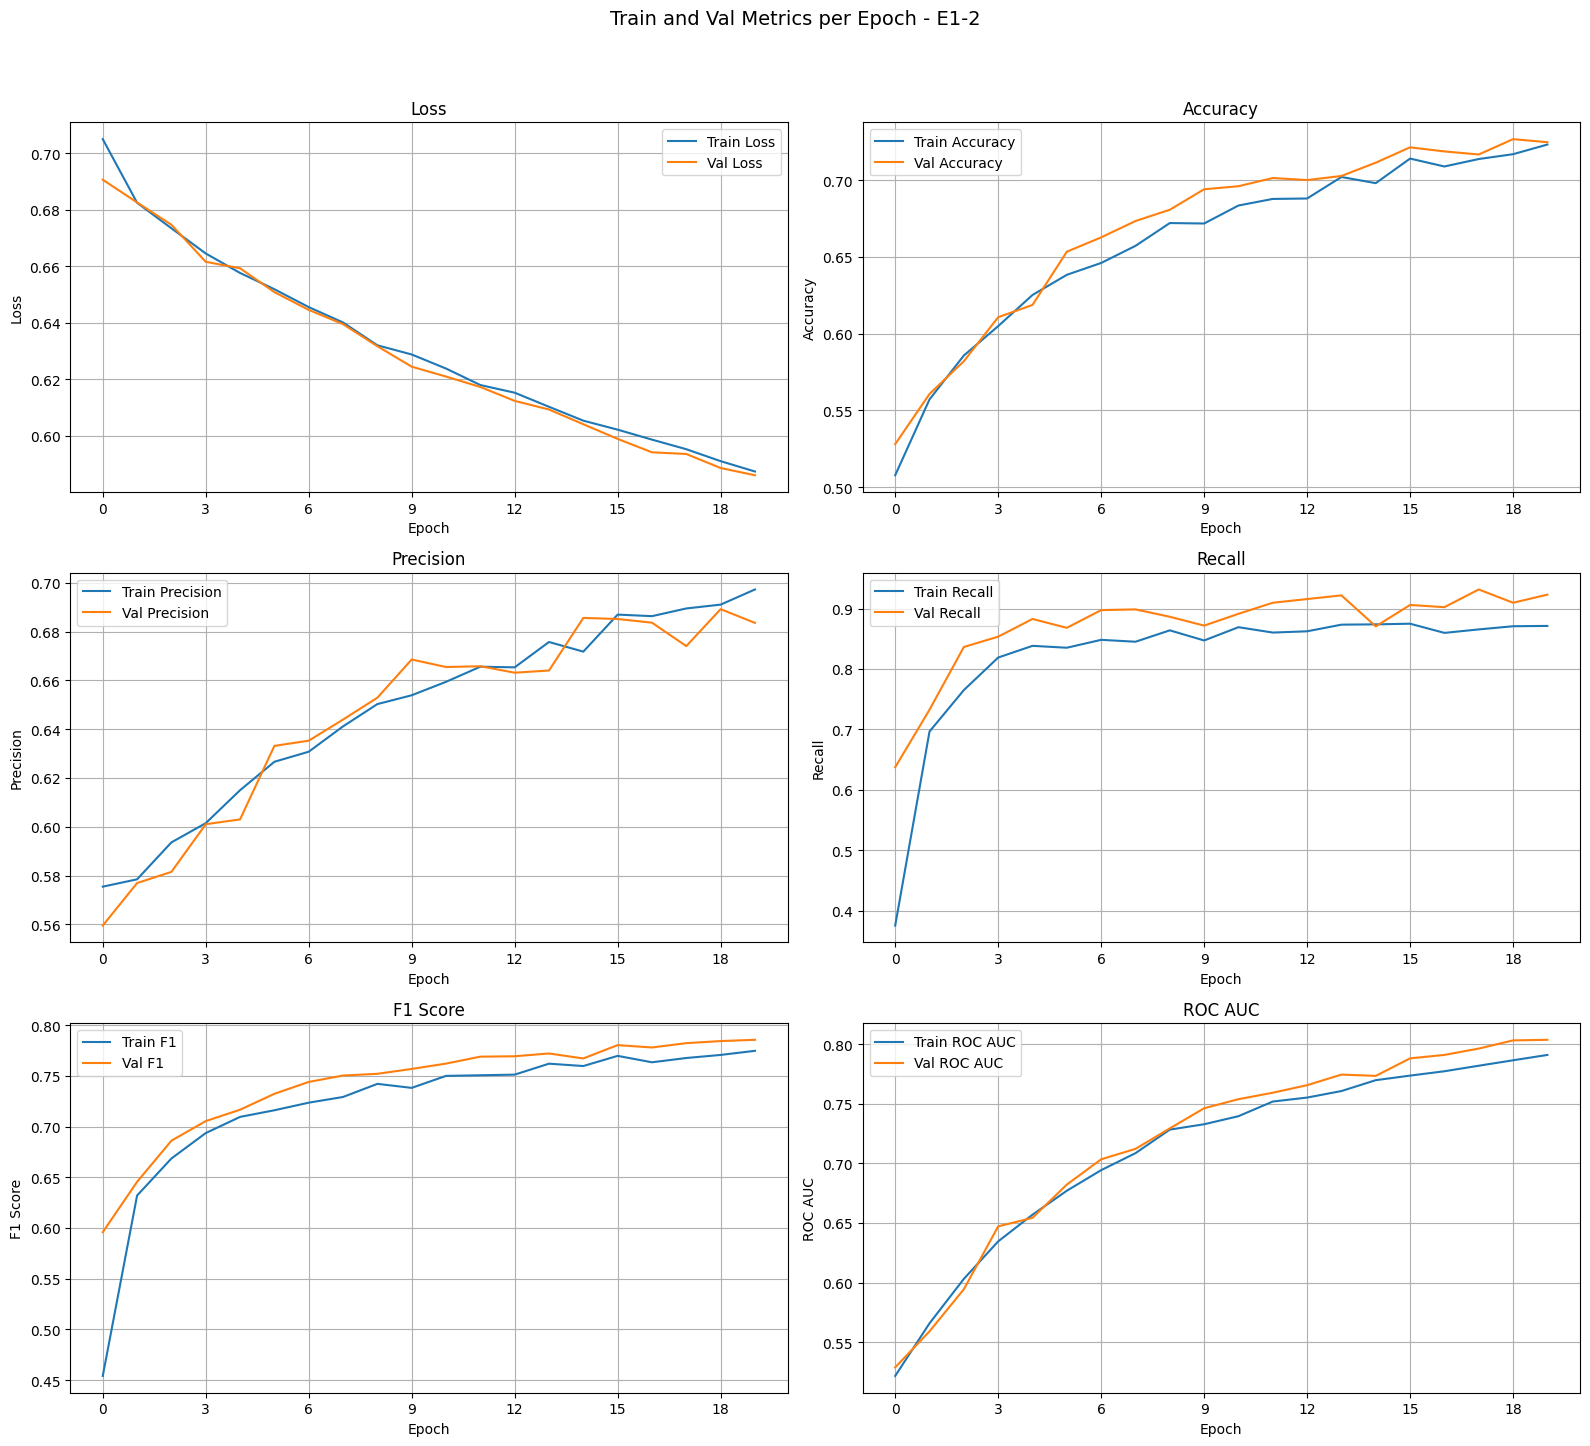

In [18]:
plot_utils.plot_train_val_metrics(df_metrics, exp_code=EXP_CODE, save_path=SAVE_FILENAME+".png")

In [19]:
df_metrics.to_csv(SAVE_FILENAME+".csv", index=False)